In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import geopandas as gpd
from sklearn.decomposition import PCA


%matplotlib inline


# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

# Import Data

In [6]:
"""
Data sources:
    Health:
        Health services coverage: https://apps.who.int/gho/data/view.main.INDEXOFESSENTIALSERVICECOVERAGEv (2017)
        Cardiovascular, diabetes, tuberculosis, COPD, HIV/AIDS: http://ghdx.healthdata.org/gbd-results-tool
        (age-standardized, prevelance) (2019)
    Air quality: https://www.stateofglobalair.org/engage (2017)
"""

def load_data():   

    # (GDP)
    file = "owid-covid-data.csv"

    raw_dataset = pd.read_csv(file, sep=',')

    dataset = raw_dataset.copy()
    display(dataset.head())
    print(dataset.columns)
       
    # Read in air pollution data
    # Source: https://www.stateofglobalair.org/engage (2017)
    air_quality_file = 'pm25-rank.xlsx'
    air_quality_data = pd.read_excel(air_quality_file)
    display(air_quality_data.head())
    print(air_quality_data.columns)
    
    # UHC index of service coverage (SCI) 2017
    # https://www.who.int/data/gho/indicator-metadata-registry/imr-details/4834
    # https://apps.who.int/gho/data/view.main.INDEXOFESSENTIALSERVICECOVERAGEv
    # Essentially measurement of how accessible health care is for a country
    healthcare_file = 'service_coverage_country_iso.xlsx'
    healthcare_data = pd.read_excel(healthcare_file)
    display(healthcare_data)
    print(healthcare_data.columns)
    
    # Load disease prevelance
    disease_prevalence_file = 'disease_prevalence_per_country.xlsx'
    disease_prevalence = pd.read_excel(disease_prevalence_file)
    display(disease_prevalence)
    print(disease_prevalence.columns)
    
    # Pull out countries with very low deaths
    deaths = dataset.groupby('iso_code', as_index=False)['total_deaths'].sum()
    display(deaths)
    low_deaths = deaths[deaths['total_deaths'] < 50]
    
    # Keep only one record for each country
    country_data = dataset.drop_duplicates(subset='iso_code').reset_index(drop=True)
       
    # Join on location    
    comb_data = country_data.join(air_quality_data.set_index('iso'), on='iso_code')
    comb_data = comb_data.join(healthcare_data.set_index('iso'), on='iso_code')
    comb_data = comb_data.join(disease_prevalence.set_index('iso'), on='iso_code')
    
    display(comb_data)

    return comb_data, low_deaths


In [7]:
dataset, low_deaths = load_data()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
0,ABW,North America,Aruba,2020-03-13,2.0,2.0,NaN,NaN,0.0,NaN,...,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29,NaN
1,ABW,North America,Aruba,2020-03-19,NaN,NaN,0.286,NaN,NaN,0.0,...,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29,NaN
2,ABW,North America,Aruba,2020-03-20,4.0,2.0,0.286,NaN,0.0,0.0,...,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29,NaN
3,ABW,North America,Aruba,2020-03-21,NaN,NaN,0.286,NaN,NaN,0.0,...,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29,NaN
4,ABW,North America,Aruba,2020-03-22,NaN,NaN,0.286,NaN,NaN,0.0,...,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29,NaN


Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'total_tests', 'new_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'tests_per_case', 'positive_rate', 'tests_units', 'stringency_index',
       'population', 'population_density', 'median_age', 'aged_65_older',
       'aged_70_older', 'gdp_per_capita', 'extreme_poverty',
     

,iso,Location,Year,Average (µg/m3),Median (µg/m3),Lower (µg/m3),Upper (µg/m3)
0,NPL,Nepal,2017,99.734374,94.463081,44.638787,179.536383
1,NER,Niger,2017,94.053818,70.585413,18.649513,306.788827
2,QAT,Qatar,2017,91.187328,88.749850,55.458277,140.690798
3,IND,India,2017,90.873210,91.326066,67.487877,113.571197
4,SAU,Saudi Arabia,2017,87.945447,78.564190,29.603935,197.880461


Index(['iso', 'Location', 'Year', 'Average (µg/m3)', 'Median (µg/m3)',
       'Lower (µg/m3)', 'Upper (µg/m3)'],
      dtype='object')


,Country,UHC index of service coverage (SCI),"UHC SCI components: Reproductive, maternal, newborn and child health",UHC SCI components: Infectious diseases,UHC SCI components: Noncommunicable diseases,UHC SCI components: Service capacity and access,iso
0,Afghanistan,37,44,32,56,24,AFG
1,Albania,59,45,69,56,69,ALB
2,Algeria,78,75,78,69,91,DZA
3,Angola,40,45,23,68,35,AGO
4,Antigua and Barbuda,73,86,65,72,70,ATG
...,...,...,...,...,...,...,...
178,Venezuela (Bolivarian Republic of),74,76,67,79,75,Unknown
179,Viet Nam,75,82,73,64,83,VNM
180,Yemen,42,39,43,64,29,YEM
181,Zambia,53,70,49,69,34,ZMB


Index(['Country', 'UHC index of service coverage (SCI)',
       'UHC SCI components: Reproductive, maternal, newborn and child health',
       'UHC SCI components:  Infectious diseases',
       'UHC SCI components: Noncommunicable diseases',
       'UHC SCI components: Service capacity and access', 'iso'],
      dtype='object')


,country,cardiovasc,chronic_kidney,copd,diabetes_2,total_cancers,iso
0,Afghanistan,0.085553,0.097536,0.022220,0.088591,0.004035,AFG
1,Albania,0.077390,0.079344,0.017060,0.033545,0.009294,ALB
2,Algeria,0.082137,0.112942,0.018931,0.081272,0.006090,DZA
3,American Samoa,0.077091,0.126094,0.014456,0.209105,0.008576,ASM
4,Andorra,0.056400,0.061629,0.035445,0.044844,0.025319,AND
...,...,...,...,...,...,...,...
199,Venezuela (Bolivarian Republic of),0.046694,0.118347,0.020956,0.075567,0.011421,VEN
200,Viet Nam,0.057934,0.103858,0.030090,0.047703,0.007842,VNM
201,Yemen,0.083621,0.090789,0.021268,0.048273,0.003524,YEM
202,Zambia,0.063513,0.060634,0.016822,0.035912,0.005063,ZMB


Index(['country', 'cardiovasc', 'chronic_kidney', 'copd', 'diabetes_2',
       'total_cancers', 'iso'],
      dtype='object')


,iso_code,total_deaths
0,ABW,3015.0
1,AFG,220824.0
2,AGO,22098.0
3,AIA,0.0
4,ALB,50410.0
...,...,...
210,WLF,0.0
211,YEM,85369.0
212,ZAF,2046047.0
213,ZMB,38722.0


,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,"UHC SCI components: Reproductive, maternal, newborn and child health",UHC SCI components: Infectious diseases,UHC SCI components: Noncommunicable diseases,UHC SCI components: Service capacity and access,country,cardiovasc,chronic_kidney,copd,diabetes_2,total_cancers
0,ABW,North America,Aruba,2020-03-13,2.0,2.0,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2019-12-31,NaN,0.0,NaN,NaN,0.0,NaN,...,44.0,32.0,56.0,24.0,Afghanistan,0.085553,0.097536,0.022220,0.088591,0.004035
2,AGO,Africa,Angola,2020-03-22,2.0,2.0,NaN,NaN,0.0,NaN,...,45.0,23.0,68.0,35.0,Angola,0.066969,0.060196,0.017916,0.049848,0.003661
3,AIA,North America,Anguilla,2020-03-27,2.0,2.0,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ALB,Europe,Albania,2020-03-09,2.0,2.0,NaN,NaN,0.0,NaN,...,45.0,69.0,56.0,69.0,Albania,0.077390,0.079344,0.017060,0.033545,0.009294
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,ZAF,Africa,South Africa,2020-02-07,NaN,NaN,NaN,NaN,NaN,NaN,...,79.0,62.0,58.0,80.0,South Africa,0.069851,0.081581,0.023379,0.058139,0.005498
212,ZMB,Africa,Zambia,2020-03-19,2.0,2.0,NaN,NaN,0.0,NaN,...,70.0,49.0,69.0,34.0,Zambia,0.063513,0.060634,0.016822,0.035912,0.005063
213,ZWE,Africa,Zimbabwe,2020-03-21,1.0,1.0,NaN,NaN,0.0,NaN,...,72.0,50.0,68.0,35.0,Zimbabwe,0.067670,0.076168,0.020851,0.060557,0.006149
214,OWID_WRL,NaN,World,2019-12-31,27.0,27.0,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [105]:
low_deaths.merge(dataset, how='inner', on='iso_code')[['location', 'total_deaths_x']]

,location,total_deaths_x
0,Anguilla,0.0
1,Bhutan,0.0
2,Dominica,0.0
3,Eritrea,0.0
4,Falkland Islands,0.0
5,Faeroe Islands,0.0
6,Gibraltar,21.0
7,Grenada,0.0
8,Greenland,0.0
9,Hong Kong,0.0


## Filtering and Cleaning

In [8]:
#relevant_columns = ['iso_code', 'location', 'population_density', 'median_age', 'aged_65_older', 'aged_70_older', 'gdp_per_capita', 'extreme_poverty', 'cardiovasc_death_rate', 'diabetes_prevalence', 'female_smokers', 'male_smokers', 'life_expectancy', 'human_development_index']

relevant_columns = [
    'iso_code', 
    'location', 
    'Average (µg/m3)', 
    'cardiovasc',
    'chronic_kidney',
    'copd',
    'diabetes_2',
    'total_cancers',
    'aged_65_older', 
    'UHC index of service coverage (SCI)', 
    'gdp_per_capita', 
    'human_development_index']

def clean_data(relevant_columns, dataset):
    # Keep only relevant data
    dataset = dataset[relevant_columns]
    
    # For now, we'll deal with missing values as follows:
    # 1. Drop all rows with 5 or more NaNs
    # 2. For remaining rows, drop all columns with NaN

#     nulls_per_row = country_data.isnull().sum(axis=1)
#     rows_to_drop = nulls_per_row >= 3
#     full_country_data = country_data[~rows_to_drop]
#     full_country_data = full_country_data.dropna(axis=1)
#     full_country_data.set_index('iso_code', inplace=True)

    # Try dropping everybody with nulls
    nulls_per_row = dataset.isnull().sum(axis=1)
    rows_to_drop = nulls_per_row >= 1
    full_country_data = dataset[~rows_to_drop]
    full_country_data.set_index('iso_code', inplace=True)
    
    return full_country_data
    

In [9]:
full_country_data = clean_data(relevant_columns, dataset)
full_country_data

,location,Average (µg/m3),cardiovasc,chronic_kidney,copd,diabetes_2,total_cancers,aged_65_older,UHC index of service coverage (SCI),gdp_per_capita,human_development_index
iso_code,,,,,,,,,,,
AFG,Afghanistan,56.910808,0.085553,0.097536,0.022220,0.088591,0.004035,2.581,37.0,1803.987,0.498
AGO,Angola,32.388505,0.066969,0.060196,0.017916,0.049848,0.003661,2.405,40.0,5819.495,0.581
ALB,Albania,18.200603,0.077390,0.079344,0.017060,0.033545,0.009294,13.188,59.0,11803.431,0.785
ARE,United Arab Emirates,40.917510,0.089068,0.120949,0.030770,0.116674,0.007601,1.144,76.0,67293.483,0.863
ARG,Argentina,13.311834,0.055034,0.075635,0.031957,0.052296,0.011912,11.198,76.0,18933.907,0.825
...,...,...,...,...,...,...,...,...,...,...,...
VUT,Vanuatu,11.652777,0.076038,0.104658,0.016749,0.107841,0.004648,4.394,48.0,2921.909,0.603
YEM,Yemen,50.456007,0.083621,0.090789,0.021268,0.048273,0.003524,2.922,42.0,1479.147,0.452
ZAF,South Africa,25.102205,0.069851,0.081581,0.023379,0.058139,0.005498,5.344,69.0,12294.876,0.699


In [10]:
iso_code_to_name = full_country_data['location']

# Cluster the countries

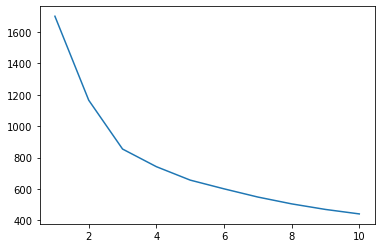

In [11]:
def elbow_loss(data):
    if 'location' in data.columns:
        data = data.drop(['location'], axis=1)
        
    # Normalize the data first
    scaler = StandardScaler()
    data = scaler.fit_transform(data)   

    # Fit cluster number use elbow method
    costs = []
    clusters = [i for i in range(1, 11)]

    for n in clusters:
        kmeans = KMeans(n_clusters=n, init='k-means++', n_init=20)
        kmeans.fit(data)
        costs.append(kmeans.inertia_)

    plt.plot(clusters, costs)
    
elbow_loss(full_country_data)

In [12]:
def cluster(data, clusters):    
    kmeans = KMeans(n_clusters=clusters, init='k-means++', n_init=20)
    if 'location' in data.columns:
        data = data.drop(['location'], axis=1)
        
    kmeans.fit(data)
    
    labels = kmeans.labels_
    print(len(labels))
    print(labels)
    
    # Show which importance of variables
    
    data['cluster'] = labels
    country_cluster = data[['cluster']]

    return country_cluster

In [13]:
country_cluster = cluster(full_country_data, 5)
country_cluster.head()

170
[0 0 0 4 2 0 2 1 1 2 0 1 0 0 0 2 1 2 0 2 0 0 2 2 4 0 2 0 1 4 2 2 0 0 0 2 0
 0 2 1 1 1 0 1 2 2 0 0 0 1 2 0 1 0 1 2 1 0 0 0 0 0 2 2 2 0 0 0 2 0 2 0 0 4
 2 1 1 1 0 0 1 2 0 0 0 4 0 2 0 2 2 0 0 2 3 2 0 0 0 2 2 2 0 1 0 2 0 0 0 2 0
 2 0 0 0 0 1 4 0 1 1 0 2 0 0 0 2 2 0 3 2 2 0 1 0 0 3 0 0 0 2 0 0 2 2 1 1 0
 2 0 0 2 0 0 2 0 2 0 0 0 2 4 0 0 0 0 0 0 0 0]


,cluster
iso_code,
AFG,0
AGO,0
ALB,0
ARE,4
ARG,2


# Map plot

In [14]:
def build_geodata(shapefile, data):
    map_df = gpd.read_file(shapefile)
    gdf = map_df[['ADM0_A3', 'geometry']].to_crs('+proj=robin')
    
    # Merged is a dataframe with the columns ['ADMO_A3', 'geometry', 'location', 'cluster']
    merged = gdf.merge(country_cluster, how='outer', left_on='ADM0_A3', right_on='iso_code')
    
#     # Replace missing cluster with '-1' for color coding purposes
#     merged['cluster'].fillna(value=-1, inplace=True)
#     merged[merged['cluster'].isnull()]    # Should be empty now
    return merged

shapefile = "shape_files/ne_10m_admin_0_countries_lakes.shp"

map_df = gpd.read_file(shapefile)

In [15]:
merged = build_geodata(shapefile, country_cluster)
merged.sample(8)

,ADM0_A3,geometry,cluster
178,MDG,"MULTIPOLYGON (((4103988.349 -2179260.654, 4103...",0.0
165,HKG,"MULTIPOLYGON (((10552442.949 2412392.589, 1055...",NaN
206,BLM,"POLYGON ((-5851869.438 1912509.989, -5852914.1...",NaN
231,WLF,"MULTIPOLYGON (((-16678688.264 -1523378.446, -1...",NaN
167,CYN,"MULTIPOLYGON (((3018977.918 3750701.371, 30191...",NaN
190,PYF,"MULTIPOLYGON (((-12591070.927 -2355550.468, -1...",NaN
182,ABW,"POLYGON ((-6566421.832 1345196.571, -6561069.0...",NaN
99,SEN,"POLYGON ((-1147439.184 1580207.556, -1146770.7...",0.0


In [16]:
keys = list(merged['cluster'].unique())
color_range = list(np.linspace(0, 1, len(keys), endpoint=False))
colors = [plt.cm.tab20b(x) for x in color_range]
color_dict = dict(zip(keys, colors))
color_dict[-1] = 'lightgray'

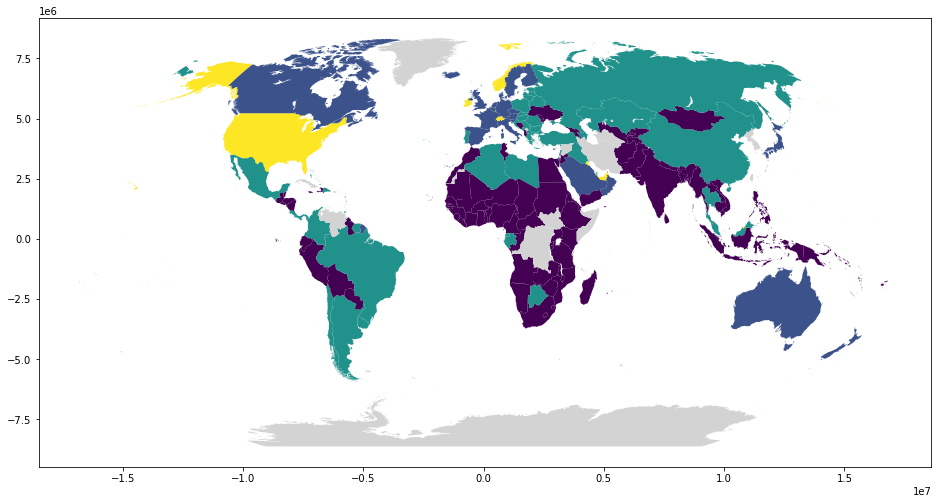

In [17]:
import mapclassify
from matplotlib.colors import LinearSegmentedColormap

ax = merged.plot(column='cluster', 
                  figsize = (16, 10),
                  missing_kwds={'color': 'lightgrey'},
                  legend=False)

plt.savefig('country_cluster.png')

,ADM0_A3,geometry,cluster
9,CHN,"MULTIPOLYGON (((7341533.511 3229629.092, 73418...",3.0


# Trying PCA

In [18]:
# Load in the data
df = dataset.copy()
df.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,"UHC SCI components: Reproductive, maternal, newborn and child health",UHC SCI components: Infectious diseases,UHC SCI components: Noncommunicable diseases,UHC SCI components: Service capacity and access,country,cardiovasc,chronic_kidney,copd,diabetes_2,total_cancers
0,ABW,North America,Aruba,2020-03-13,2.0,2.0,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2019-12-31,NaN,0.0,NaN,NaN,0.0,NaN,...,44.0,32.0,56.0,24.0,Afghanistan,0.085553,0.097536,0.022220,0.088591,0.004035
2,AGO,Africa,Angola,2020-03-22,2.0,2.0,NaN,NaN,0.0,NaN,...,45.0,23.0,68.0,35.0,Angola,0.066969,0.060196,0.017916,0.049848,0.003661
3,AIA,North America,Anguilla,2020-03-27,2.0,2.0,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ALB,Europe,Albania,2020-03-09,2.0,2.0,NaN,NaN,0.0,NaN,...,45.0,69.0,56.0,69.0,Albania,0.077390,0.079344,0.017060,0.033545,0.009294


In [19]:
full_country_data = clean_data(relevant_columns, dataset).drop(['location'], axis=1)
full_country_data

,Average (µg/m3),cardiovasc,chronic_kidney,copd,diabetes_2,total_cancers,aged_65_older,UHC index of service coverage (SCI),gdp_per_capita,human_development_index
iso_code,,,,,,,,,,
AFG,56.910808,0.085553,0.097536,0.022220,0.088591,0.004035,2.581,37.0,1803.987,0.498
AGO,32.388505,0.066969,0.060196,0.017916,0.049848,0.003661,2.405,40.0,5819.495,0.581
ALB,18.200603,0.077390,0.079344,0.017060,0.033545,0.009294,13.188,59.0,11803.431,0.785
ARE,40.917510,0.089068,0.120949,0.030770,0.116674,0.007601,1.144,76.0,67293.483,0.863
ARG,13.311834,0.055034,0.075635,0.031957,0.052296,0.011912,11.198,76.0,18933.907,0.825
...,...,...,...,...,...,...,...,...,...,...
VUT,11.652777,0.076038,0.104658,0.016749,0.107841,0.004648,4.394,48.0,2921.909,0.603
YEM,50.456007,0.083621,0.090789,0.021268,0.048273,0.003524,2.922,42.0,1479.147,0.452
ZAF,25.102205,0.069851,0.081581,0.023379,0.058139,0.005498,5.344,69.0,12294.876,0.699


In [20]:
def do_pca(data, retained_var=0.99):
       
    # Standardize the data to have a mean of ~0 and a variance of 1
    X_std = StandardScaler().fit_transform(data)# Create a PCA instance: pca
    
    n = len(data.columns)
    model = PCA(n_components=n)
    model.fit_transform(X_std)
    var = model.explained_variance_ratio_.cumsum()
    print(var)
                
    for i in range(n):
        if var[i] >= retained_var:
            pca = PCA(n_components=i)
    
            principalComponents = pca.fit_transform(X_std)# Plot the explained variances
            features = range(pca.n_components_)
            plt.bar(features, pca.explained_variance_ratio_, color='black')
            plt.xlabel('PCA features')
            plt.ylabel('variance %')
            plt.xticks(features)# Save components to a DataFrame
            PCA_components = pd.DataFrame(principalComponents)
            
            break
    
    return PCA_components

[0.454 0.647 0.747 0.834 0.892 0.938 0.967 0.984 0.995 1.   ]


,0,1,2,3,4,5,6,7
0,-2.793575,1.457884,1.439419,0.173391,-0.560648,0.811197,0.502865,0.507159
1,-2.370774,-0.968331,0.131448,-0.063173,0.597744,0.598264,-0.228980,-0.003668
2,0.035466,-0.581158,0.487338,-1.594762,0.061809,-0.294659,-0.099702,0.236009
3,1.283939,3.476876,1.510861,1.435126,-0.173299,0.633438,-1.603616,-0.037005
4,1.407670,-1.236365,-0.872089,0.705533,-0.409421,-0.024671,-0.002249,-0.469169
...,...,...,...,...,...,...,...,...
165,-1.456457,1.629467,-0.752565,-0.757033,-0.299691,1.586334,0.109308,0.369085
166,-2.867364,0.320915,1.374312,-0.318178,-0.639332,0.081038,-0.126936,0.412926
167,-0.475194,-0.046562,-0.111113,-0.041377,-0.243140,0.065734,-0.393041,-0.669183
168,-1.936181,-1.293895,-0.287133,-0.301023,0.570720,0.064934,-0.414426,-0.499712


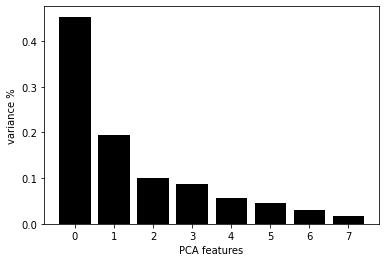

In [21]:
PCA_components = do_pca(full_country_data)
PCA_components

In [22]:
def elbow_loss_pca(data):
    loss = []
    
    ks = range(1, 10)
    for k in range(1, 10):
        # Create a KMeans instance with k clusters: model
        model = KMeans(n_clusters=k)

        # Fit model to samples
        model.fit(data)

        # Append the inertia to the list of inertias
        loss.append(model.inertia_)
        
    plt.plot(ks, loss, '-o', color='black')
    plt.xlabel('number of clusters, k')
    plt.ylabel('inertia')
    plt.xticks(ks)
    plt.show()

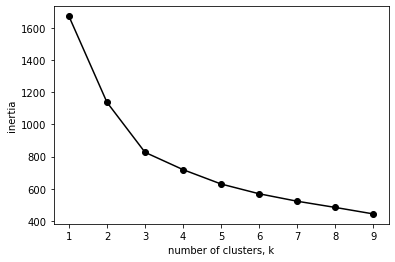

In [23]:
elbow_loss_pca(PCA_components)